#### Taller 
##### Procesamiento Distribuido en la Nube
##### Laura Espinosa - Carlos Jaramillo


###### Configuracion inicial antes de correr Spark
En un terminal, de SageMaker, se debe correr los siguientes comandos para garantizar que se tiene la configuracion adecuada de librerias
```
$sudo apt update
$java --version
$sudo apt install default-jre
$java --version
$update-alternatives --config java
```

Teniendo en cuenta la version de java y ruta , se debe configurar la variable de entorno

```
import os
os.environ["SPARK_VERSION"] = '3.3'
os.environ["JAVA_HOME"] = '/usr/lib/jvm/java-11-openjdk-amd64/'
```

Una vez se tenga esto listo, se pueden instalar las librerias con `pip install`

In [1]:
import os
os.environ["SPARK_VERSION"] = '3.3'
os.environ["JAVA_HOME"] = '/usr/lib/jvm/java-11-openjdk-amd64/'

###### Instalacion de Librerias

In [2]:
!pip install pydeequ==1.2.0
!pip install pyspark
!pip install sagemaker_pyspark
!pip install seaborn

###### Uso de Librerias

In [3]:
import pyspark
import sagemaker_pyspark
import pydeequ

In [4]:
from pyspark.sql import SparkSession, Row, DataFrame
import pandas as pd
import sagemaker_pyspark

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum as spark_sum

import pydeequ
from pydeequ.repository import *
from pydeequ.analyzers import *
from pydeequ.verification import *
from pydeequ.anomaly_detection import *
from pydeequ.analyzers import *

from pydeequ.profiles import *

import matplotlib.pyplot as plt
import seaborn as sns

##### Creacion de la sesion de Spark
utilizando las configuraciones de paquete maven

In [5]:
classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = (SparkSession
    .builder
    .config("spark.driver.extraClassPath", classpath)
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate())

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
com.amazon.deequ#deequ added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-40344158-d4cd-4153-8a96-f02b1707119e;1.0
	confs: [default]
	found com.amazon.deequ#deequ;2.0.3-spark-3.3 in central
	found org.scala-lang#scala-reflect;2.12.10 in central
	found org.scalanlp#breeze_2.12;0.13.2 in central
	found org.scalanlp#breeze-macros_2.12;0.13.2 in central
	found com.github.fommil.netlib#core;1.1.2 in central
	found net.sf.opencsv#opencsv;2.3 in central
	found com.github.rwl#jtransforms;2.4.0 in central
	found junit#junit;4.8.2 in central
	found org.apache.commons#commons-math3;3.2 in central
	found org.spire-math#spire_2.12;0.13.0 in central
	found org.spire-math#spire-macros_2.12;0.13.0 in central
	found org.typelevel#machinist_2.12;0.6.1 in central
	found com.chuusai#shapeless_2.12;2.3.2 in central
	found org.typelevel#macro-co

24/09/09 03:52:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [6]:
# Programmatic way to define a schema
tesla_schema = StructType([StructField('VIN', StringType(), True),
 StructField('County', StringType(), True),
 StructField('City', StringType(), True),#IntegerType
 StructField('State', StringType(), True),
 StructField('Postal_Code', IntegerType(), True),
 StructField('Model_Year', IntegerType(), True),
 StructField('Make', StringType(), True),
 StructField('Model', StringType(), True),
 StructField('Electric_Vehicle_Type', StringType(), True),
 StructField('CAFV', StringType(), True),
 StructField('Electric_Range', IntegerType(), True),
 StructField('Base_MSRP', IntegerType(), True),
 StructField('Legislative_District', IntegerType(), True),
 StructField('DOL_Vehicle_ID', IntegerType(), True),
 StructField('Vehicle_Location', StringType(), True),
 StructField('Electric_Utility', StringType(), True),
 StructField('2020_Census_Tract', LongType(), True)])

In [7]:
#csv_url = "https://raw.githubusercontent.com/carlosjara/MCD_PDN/main/Clase_3_StepFunction/data/Electric_Vehicle_Population_Data.csv"
#falla al traerlo de git, cargar "manualmente" 
df = spark.read.csv("data/Electric_Vehicle_Population_Data.csv", header=True,schema=tesla_schema)

In [8]:
print(df.printSchema())

root
 |-- VIN: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal_Code: integer (nullable = true)
 |-- Model_Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric_Vehicle_Type: string (nullable = true)
 |-- CAFV: string (nullable = true)
 |-- Electric_Range: integer (nullable = true)
 |-- Base_MSRP: integer (nullable = true)
 |-- Legislative_District: integer (nullable = true)
 |-- DOL_Vehicle_ID: integer (nullable = true)
 |-- Vehicle_Location: string (nullable = true)
 |-- Electric_Utility: string (nullable = true)
 |-- 2020_Census_Tract: long (nullable = true)

None


In [9]:
#display(df.head(5))

24/09/09 03:52:47 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract
 Schema: VIN, County, City, State, Postal_Code, Model_Year, Make, Model, Electric_Vehicle_Type, CAFV, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, Vehicle_Location, Electric_Utility, 2020_Census_Tract
Expected: VIN but found: VIN (1-10)
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


[Row(VIN='5YJ3E1EB0J', County='Thurston', City='Olympia', State='WA', Postal_Code=98512, Model_Year=2018, Make='TESLA', Model='MODEL 3', Electric_Vehicle_Type='Battery Electric Vehicle (BEV)', CAFV='Clean Alternative Fuel Vehicle Eligible', Electric_Range=215, Base_MSRP=0, Legislative_District=35, DOL_Vehicle_ID=104823078, Vehicle_Location='POINT (-122.957046 46.991391)', Electric_Utility='PUGET SOUND ENERGY INC', 2020_Census_Tract=53067012730),
 Row(VIN='WA1AAAGE9M', County='Kitsap', City='Port Orchard', State='WA', Postal_Code=98367, Model_Year=2021, Make='AUDI', Model='E-TRON', Electric_Vehicle_Type='Battery Electric Vehicle (BEV)', CAFV='Clean Alternative Fuel Vehicle Eligible', Electric_Range=222, Base_MSRP=0, Legislative_District=35, DOL_Vehicle_ID=156660507, Vehicle_Location='POINT (-122.6530052 47.4739066)', Electric_Utility='PUGET SOUND ENERGY INC', 2020_Census_Tract=53035092901),
 Row(VIN='5YJ3E1EA2J', County='Yakima', City='Yakima', State='WA', Postal_Code=98902, Model_Year=

In [10]:
# Contar nulos por columna
df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

24/09/09 03:52:49 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract
 Schema: VIN, County, City, State, Postal_Code, Model_Year, Make, Model, Electric_Vehicle_Type, CAFV, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, Vehicle_Location, Electric_Utility, 2020_Census_Tract
Expected: VIN but found: VIN (1-10)
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN|County|City|State|Postal_Code|Model_Year|Make|Model|Electric_Vehicle_Type|CAFV|Electric_Range|Base_MSRP|Legislative_District|DOL_Vehicle_ID|Vehicle_Location|Electric_Utility|2020_Census_Tract|
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|  0|     4|   4|    0|          4|         0|   0|    0|                    0|   0|             0|        0|                 442|             0|               8|               4|                4|
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+



In [11]:
# Contar duplicados
df.select("*").groupBy(df.columns).count().filter("count > 1").show()

24/09/09 03:53:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract
 Schema: VIN, County, City, State, Postal_Code, Model_Year, Make, Model, Electric_Vehicle_Type, CAFV, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, Vehicle_Location, Electric_Utility, 2020_Census_Tract
Expected: VIN but found: VIN (1-10)
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-----+
|VIN|County|City|State|Postal_Code|Model_Year|Make|Model|Electric_Vehicle_Type|CAFV|Electric_Range|Base_MSRP|Legislative_District|DOL_Vehicle_ID|Vehicle_Location|Electric_Utility|2020_Census_Tract|count|
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-----+
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-----+



In [12]:
df.describe().show()

24/09/09 03:53:15 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract
 Schema: VIN, County, City, State, Postal_Code, Model_Year, Make, Model, Electric_Vehicle_Type, CAFV, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, Vehicle_Location, Electric_Utility, 2020_Census_Tract
Expected: VIN but found: VIN (1-10)
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


+-------+----------+------+--------+------+------------------+------------------+--------------------+------------------+---------------------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|summary|       VIN|County|    City| State|       Postal_Code|        Model_Year|                Make|             Model|Electric_Vehicle_Type|                CAFV|   Electric_Range|        Base_MSRP|Legislative_District|     DOL_Vehicle_ID|    Vehicle_Location|    Electric_Utility|   2020_Census_Tract|
+-------+----------+------+--------+------+------------------+------------------+--------------------+------------------+---------------------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|  count|    200048|200044|  200044|200048|            200044|            200048|    

In [13]:
df.groupBy("Make").count().orderBy("count", ascending=False).show()

+-------------+-----+
|         Make|count|
+-------------+-----+
|        TESLA|88083|
|    CHEVROLET|14806|
|       NISSAN|14416|
|         FORD|10547|
|          KIA| 8763|
|          BMW| 8295|
|       TOYOTA| 7681|
|   VOLKSWAGEN| 5565|
|      HYUNDAI| 5476|
|         JEEP| 5288|
|       RIVIAN| 5213|
|        VOLVO| 4707|
|         AUDI| 4074|
|     CHRYSLER| 3620|
|MERCEDES-BENZ| 1879|
|      PORSCHE| 1220|
|       SUBARU| 1167|
|     POLESTAR| 1112|
|         MINI| 1011|
|   MITSUBISHI| 1007|
+-------------+-----+
only showing top 20 rows



In [14]:
df.groupBy("CAFV").count().orderBy("count", ascending=False).show()

24/09/09 03:54:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Clean Alternative Fuel Vehicle (CAFV) Eligibility
 Schema: CAFV
Expected: CAFV but found: Clean Alternative Fuel Vehicle (CAFV) Eligibility
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


+--------------------+------+
|                CAFV| count|
+--------------------+------+
|Eligibility unkno...|109401|
|Clean Alternative...| 69622|
|Not eligible due ...| 21025|
+--------------------+------+



24/09/09 03:54:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract
 Schema: VIN, County, City, State, Postal_Code, Model_Year, Make, Model, Electric_Vehicle_Type, CAFV, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, Vehicle_Location, Electric_Utility, 2020_Census_Tract
Expected: VIN but found: VIN (1-10)
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


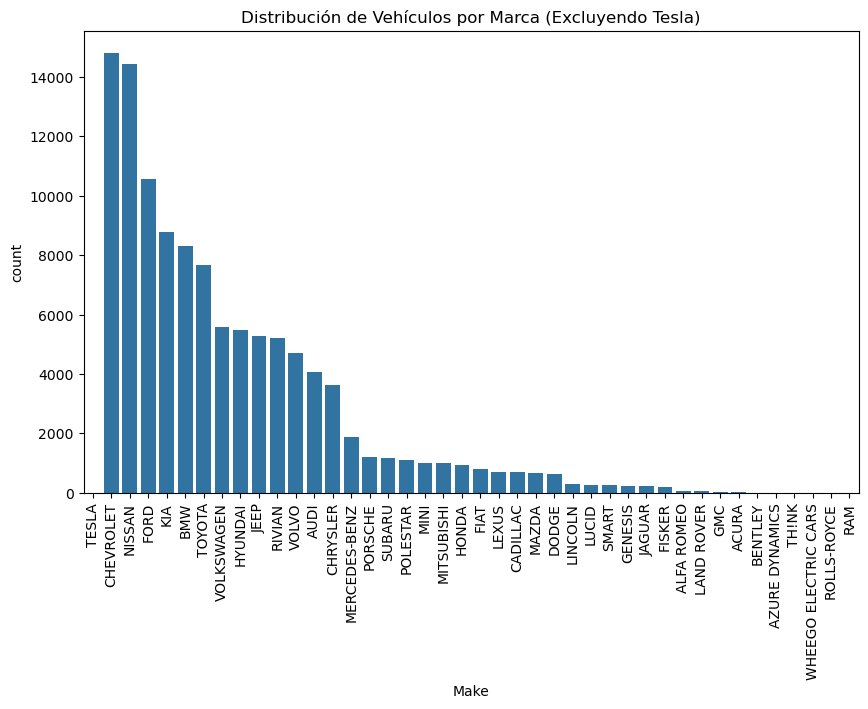

In [15]:
# Convertir a pandas Para graficar
pandas_df = df.toPandas()

plt.figure(figsize=(10,6))
# Filtrar el DataFrame y crear el gráfico de barras en una línea
sns.countplot(data=pandas_df[pandas_df['Make'] != 'TESLA'], x='Make', order=pandas_df['Make'].value_counts().index)

plt.xticks(rotation=90)
plt.title('Distribución de Vehículos por Marca (Excluyendo Tesla)')
plt.show()


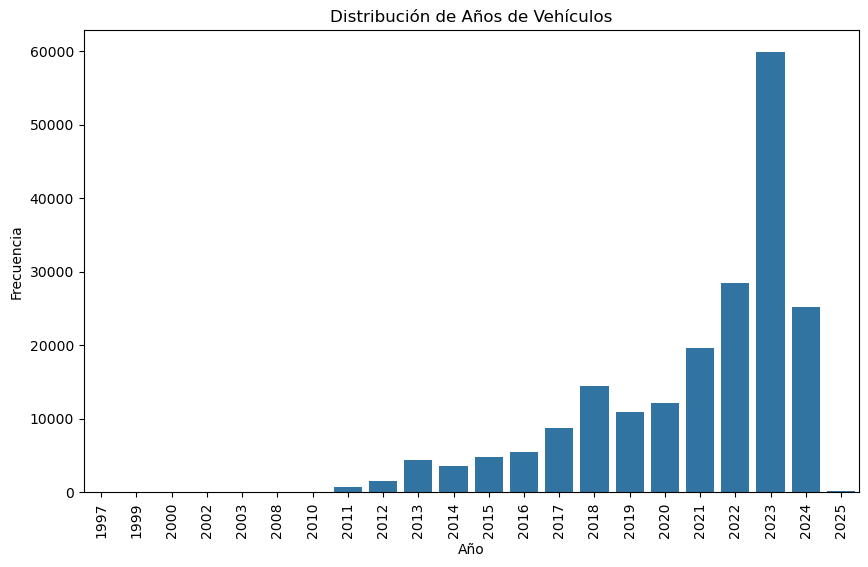

In [16]:
# Contar la frecuencia de cada año
year_counts = pandas_df['Model_Year'].value_counts().sort_index()
plt.figure(figsize=(10,6))

# Crear el gráfico de barras
sns.barplot(x=year_counts.index, y=year_counts.values)

plt.title('Distribución de Años de Vehículos')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

24/09/09 03:54:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Postal Code, Model Year, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID
 Schema: Postal_Code, Model_Year, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID
Expected: Postal_Code but found: Postal Code
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


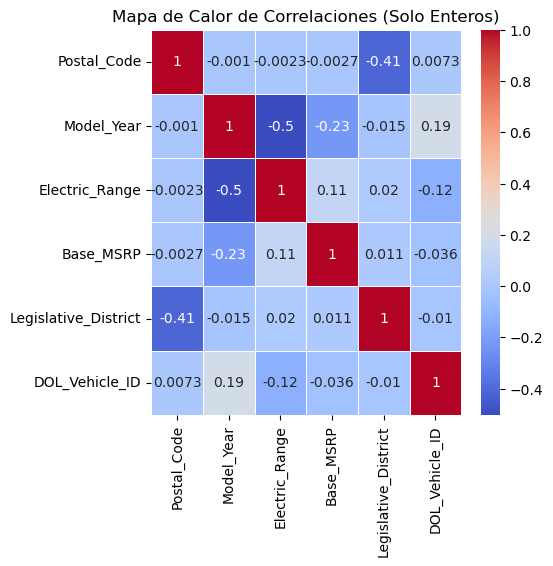

In [17]:
# Seleccionar solo columnas de tipo entero
integer_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, IntegerType)]

# Seleccionar solo esas columnas
df_integers = df.select(integer_columns)
# Convertir a pandas
pandas_df_integers = df_integers.toPandas()


plt.figure(figsize = (5,5))

# Calcular la matriz de correlación
corr_matrix = pandas_df_integers.corr()

# Crear el mapa de calor
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Mostrar el gráfico
plt.title('Mapa de Calor de Correlaciones (Solo Enteros)')
plt.show()

In [ ]:
##############################################################################################################################

In [ ]:
##############################################################################################################################

#### Usando deequ para calidad de datos

In [18]:
analysisResult = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("Electric_Range")) \
                    .addAnalyzer(Completeness("DOL_Vehicle_ID")) \
                    .addAnalyzer(Distinctness("Electric_Range")) \
                    .addAnalyzer(Mean("Base_MSRP")) \
                    .addAnalyzer(CountDistinct("Electric_Vehicle_Type")) \
                    .addAnalyzer(MaxLength("Electric_Vehicle_Type")) \
                    .addAnalyzer(Minimum("DOL_Vehicle_ID")) \
                    .addAnalyzer(Maximum("DOL_Vehicle_ID")) \
                    .run()
                    
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

24/09/09 03:54:25 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Electric Vehicle Type, Electric Range, Base MSRP, DOL Vehicle ID
 Schema: Electric_Vehicle_Type, Electric_Range, Base_MSRP, DOL_Vehicle_ID
Expected: Electric_Vehicle_Type but found: Electric Vehicle Type
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


24/09/09 03:54:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Electric Range
 Schema: Electric_Range
Expected: Electric_Range but found: Electric Range
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


24/09/09 03:54:28 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Electric Range
 Schema: Electric_Range
Expected: Electric_Range but found: Electric Range
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


24/09/09 03:54:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Electric Vehicle Type
 Schema: Electric_Vehicle_Type
Expected: Electric_Vehicle_Type but found: Electric Vehicle Type
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


24/09/09 03:54:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Electric Vehicle Type
 Schema: Electric_Vehicle_Type
Expected: Electric_Vehicle_Type but found: Electric Vehicle Type
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


+-------+--------------------+-------------+--------------------+
| entity|            instance|         name|               value|
+-------+--------------------+-------------+--------------------+
| Column|      Electric_Range| Distinctness|5.198752299448132E-4|
| Column|           Base_MSRP|         Mean|   947.5519125409902|
| Column|Electric_Vehicle_...|    MaxLength|                38.0|
|Dataset|                   *|         Size|            200048.0|
| Column|Electric_Vehicle_...|CountDistinct|                 2.0|
| Column|      DOL_Vehicle_ID| Completeness|                 1.0|
| Column|      DOL_Vehicle_ID|      Minimum|              4385.0|
| Column|      DOL_Vehicle_ID|      Maximum|        4.79254772E8|
| Column|      Electric_Range| Completeness|                 1.0|
+-------+--------------------+-------------+--------------------+



/opt/conda/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


##### Conclusiones 
Lectura del Analyzer 
##### Seleccionar otras variables y otros analyzers

###### Profiling

In [19]:
result = ColumnProfilerRunner(spark) \
            .onData(df) \
            .run()

24/09/09 03:54:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/09/09 03:54:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract
 Schema: VIN, County, City, State, Postal_Code, Model_Year, Make, Model, Electric_Vehicle_Type, CAFV, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, Vehicle_Location, Electric_Utility, 2020_Census_Tract
Expected: VIN but found: VIN (1-10)
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


24/09/09 03:54:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Postal Code, Model Year, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, 2020 Census Tract
 Schema: Postal_Code, Model_Year, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, 2020_Census_Tract
Expected: Postal_Code but found: Postal Code
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


24/09/09 03:54:52 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: VIN (1-10), County, City, State, Postal Code, Model Year, Make, Model, Electric Vehicle Type, Clean Alternative Fuel Vehicle (CAFV) Eligibility, Electric Range, Base MSRP, Legislative District, DOL Vehicle ID, Vehicle Location, Electric Utility, 2020 Census Tract
 Schema: VIN, County, City, State, Postal_Code, Model_Year, Make, Model, Electric_Vehicle_Type, CAFV, Electric_Range, Base_MSRP, Legislative_District, DOL_Vehicle_ID, Vehicle_Location, Electric_Utility, 2020_Census_Tract
Expected: VIN but found: VIN (1-10)
CSV file: file:///home/sagemaker-user/data/Electric_Vehicle_Population_Data.csv


In [20]:
for col, profile in result.profiles.items():
    print(f'Column \'{col}\'')
    print('\t',f'completeness: {profile.completeness}')
    print('\t',f'approximate number of distinct values: {profile.approximateNumDistinctValues}')
    print('\t',f'datatype: {profile.dataType}')

Column 'CAFV'
	 completeness: 1.0
	 approximate number of distinct values: 3
	 datatype: String
Column 'VIN'
	 completeness: 1.0
	 approximate number of distinct values: 12399
	 datatype: String
Column 'Make'
	 completeness: 1.0
	 approximate number of distinct values: 38
	 datatype: String
Column 'Vehicle_Location'
	 completeness: 0.9999600095976966
	 approximate number of distinct values: 953
	 datatype: String
Column 'Postal_Code'
	 completeness: 0.9999800047988483
	 approximate number of distinct values: 936
	 datatype: Integral
Column 'Electric_Utility'
	 completeness: 0.9999800047988483
	 approximate number of distinct values: 80
	 datatype: String
Column 'Legislative_District'
	 completeness: 0.9977905302727346
	 approximate number of distinct values: 49
	 datatype: Integral
Column 'Model'
	 completeness: 1.0
	 approximate number of distinct values: 146
	 datatype: String
Column 'Electric_Range'
	 completeness: 1.0
	 approximate number of distinct values: 108
	 datatype: Integra

In [21]:
totalNumber_profile = result.profiles['Electric_Range']

print(f'Statistics of \'Electric_Range\':')
print('\t',f"minimum: {totalNumber_profile.minimum}")
print('\t',f"maximum: {totalNumber_profile.maximum}")
print('\t',f"mean: {totalNumber_profile.mean}")
print('\t',f"standard deviation: {totalNumber_profile.stdDev}")

Statistics of 'Electric_Range':
	 minimum: 0.0
	 maximum: 337.0
	 mean: 53.48527853315204
	 standard deviation: 88.78607875652004


In [22]:
totalNumber_profile = result.profiles['DOL_Vehicle_ID']

print(f'Statistics of \'DOL_Vehicle_ID\':')
print('\t',f"minimum: {totalNumber_profile.minimum}")
print('\t',f"maximum: {totalNumber_profile.maximum}")
print('\t',f"mean: {totalNumber_profile.mean}")
print('\t',f"standard deviation: {totalNumber_profile.stdDev}")

Statistics of 'DOL_Vehicle_ID':
	 minimum: 4385.0
	 maximum: 479254772.0
	 mean: 226298774.6758728
	 standard deviation: 72824143.40227911


In [23]:
status_profile = result.profiles['Electric_Vehicle_Type']

print('Value distribution in \'Electric_Vehicle_Type\':')
for unique_entry in status_profile.histogram: 
    print('\t',f"{unique_entry.value} occurred {unique_entry.count} times (ratio is {unique_entry.ratio})")

Value distribution in 'Electric_Vehicle_Type':
	 Battery Electric Vehicle (BEV) occurred 156956 times (ratio is 0.7845916979924819)
	 Plug-in Hybrid Electric Vehicle (PHEV) occurred 43092 times (ratio is 0.2154083020075182)


In [24]:
status_profile = result.profiles['CAFV']

print('Value distribution in \'CAFV\':')
for unique_entry in status_profile.histogram: 
    print('\t',f"{unique_entry.value} occurred {unique_entry.count} times (ratio is {unique_entry.ratio})")

Value distribution in 'CAFV':
	 Clean Alternative Fuel Vehicle Eligible occurred 69622 times (ratio is 0.3480264736463249)
	 Not eligible due to low battery range occurred 21025 times (ratio is 0.1050997760537471)
	 Eligibility unknown as battery range has not been researched occurred 109401 times (ratio is 0.546873750299928)


In [25]:
##### Anomaly Detection